In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

Read the input data and select the statistic we want to look at.  To look at other statisics, change to "Stat_Type == 'R**2'" or "Stat_Type == 'Kendall'"

In [2]:
df = pd.read_csv("comparison.csv")
df = df.query("Stat_Type == 'Spearman'")

Look at the first few lines to make sure we have what we want

In [3]:
df.head()

,Target,Method,Stat_Type,Stat_LB,Stat_Val,Stat_UB
0,B-raf,DESC,Spearman,0.778948,0.830294,0.871099
3,B-raf,CDDD,Spearman,0.725639,0.783226,0.828333
6,B-raf,DESC,Spearman,0.769066,0.824953,0.867267
9,B-raf,CDDD,Spearman,0.730504,0.793927,0.839672
12,B-raf,DESC,Spearman,0.786877,0.834263,0.869385


Sort the table first by Target, then by Method, this way the x-axis of the plots will be in alphabetical order, making it easier to find things.

In [31]:
df.sort_values(["Target","Method"],inplace=True)

Let's see how many targets we have.  Since there are 24 targets, this is going to make it difficult to read the plots.  Let's split the dataframe into two different dataframes.  This will make it easier to visualized the results. 

In [32]:
unique_targets = df.Target.unique()
print(unique_targets)
print(len(unique_targets))

['A2a' 'ABL1' 'Acetylcholinesterase' 'Aurora-A' 'B-raf' 'COX-1' 'COX-2'
 'Cannabinoid' 'Carbonic' 'Caspase' 'Coagulation' 'Dihydrofolate'
 'Dopamine' 'Ephrin' 'Estrogen' 'Glucocorticoid' 'Glycogen' 'HERG' 'JAK2'
 'LCK' 'Monoamine' 'Vanilloid' 'erbB1' 'opioid']
24


Create two dataframes, one with the first half and one with the second half

In [24]:
t1 = df.Target.unique()[0:12]
t2 = df.Target.unique()[12:]
df1 = df[df.Target.isin(t1)]
df2 = df[df.Target.isin(t2)]

We want to make plots of the mean statistic, mean upper bound, and mean lower bound across the cross validation folds.  To do this, we will define a function to summarize the dataframe by Target and Method. 

In [25]:
def make_summary_df(df):
    summary_list = []
    gb = df.groupby(["Target", "Method"])
    for (target, method), v in gb:
        summary_list.append([target, method, v.Stat_LB.mean(), v.Stat_Val.mean(), v.Stat_UB.mean()])
    summary_df = pd.DataFrame(summary_list, columns=["Target", "Method", "Lower_Bound", "Value", "Upper_Bound"])
    return summary_df

Now lets make summary dataframes from df1 and df2.

In [33]:
sum1 = make_summary_df(df1)
sum2 = make_summary_df(df2)

I always find plots easier to interpret than data tables.  Here's function that will generate a bar plot in seaborn with user defined error bars. 

In [34]:
def barplot_with_errorbars(df, x_col, y_col, hue_col,ub_col, lb_col, y_label, x_labels='angled'):
    """
    Plot a seaborn barplot with user defined errorbars
    :param df: input data frame
    :param x_col: df column for the x axis
    :param y_col: df column for the y-axis
    :param hue_col: df column for groups to color
    :param ub_col: upper error bound for the y-axis
    :param lb_col: lower error bound for the y-axis
    :param y_label: column label for the y-axis
    :param x_labels: angle the y-axis, None=horizontal, vertical=vertical, angled=45 degrees
    :return: None
    """
    fig, ax = plt.subplots()
    sns.set(rc={'figure.figsize': (11.7, 8.27)})
    sns.set(font_scale=1.5)
    ax = sns.barplot(x=x_col, y=y_col, hue=hue_col, data=df)
    num_x = len(df[x_col].unique())
    error_lb = df[y_col] - df[lb_col]
    error_ub = df[ub_col] - df[y_col]
    pos = np.array([(x - 0.2, x + 0.2) for x in range(0, num_x)]).flatten()
    _ = plt.errorbar(x=pos, y=df[y_col],
                      yerr=[error_lb, error_ub], fmt='none', color="black")
    # matplotlib tries to put the errorbar into the legend, need to fix this
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=handles[0:2], labels=labels[0:2])
    _ = ax.set(xlabel='', ylabel=y_label)
    if x_labels == 'angled':
        fig.autofmt_xdate()
    elif x_labels == 'vertical':
        for item in ax.get_xticklabels():
            item.set_rotation(90)
    plt.ylim(0,1)

Now let's make the plot for sum1

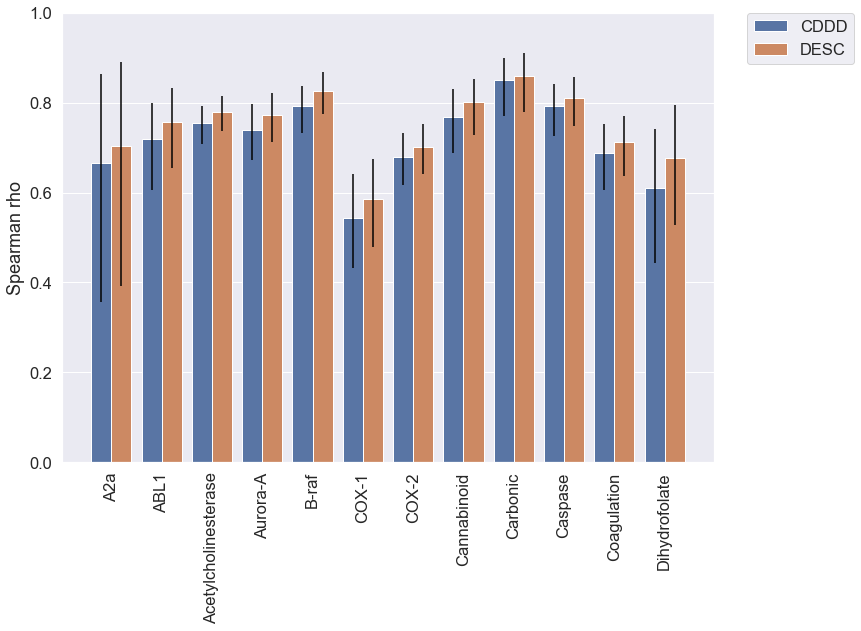

In [35]:
barplot_with_errorbars(df=sum1,
                       x_col="Target",
                       y_col="Value",
                       hue_col="Method",
                       ub_col="Lower_Bound",
                       lb_col="Upper_Bound",
                       y_label="Spearman rho",
                       x_labels="vertical")

From the plot above, it looks like the methods are not different at the 95% confidence level.  One thing I find odd, is the huge error bar for the A2a dataset.  In order to look at this more closely, let's make a boxplot of Spearman rho for each of 10 folds.  In order to do this we need to define a quick function to make the boxplots.

In [14]:
def make_boxplots(df_in,y_label):
    fig, ax = plt.subplots()
    sns.set(font_scale=1.5)
    ax = sns.boxplot(x="Target", y="Stat_Val", hue="Method", data=df_in)
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    _ = ax.set(xlabel='', ylabel=y_label)
    plt.ylim(0,1)

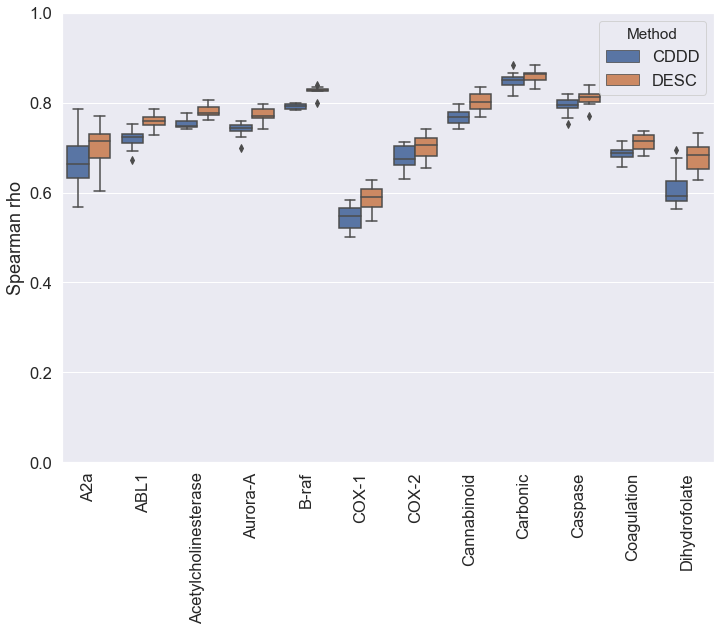

In [30]:
make_boxplots(df1,"Spearman rho")

If we look at the variablity in Spearman rho across the 10 folds, we can see that it's possible to get lucky (or unlucky) and get a good or poor correlation with a particular fold on a dataset.

Let's repeat this for the second dataframe. 

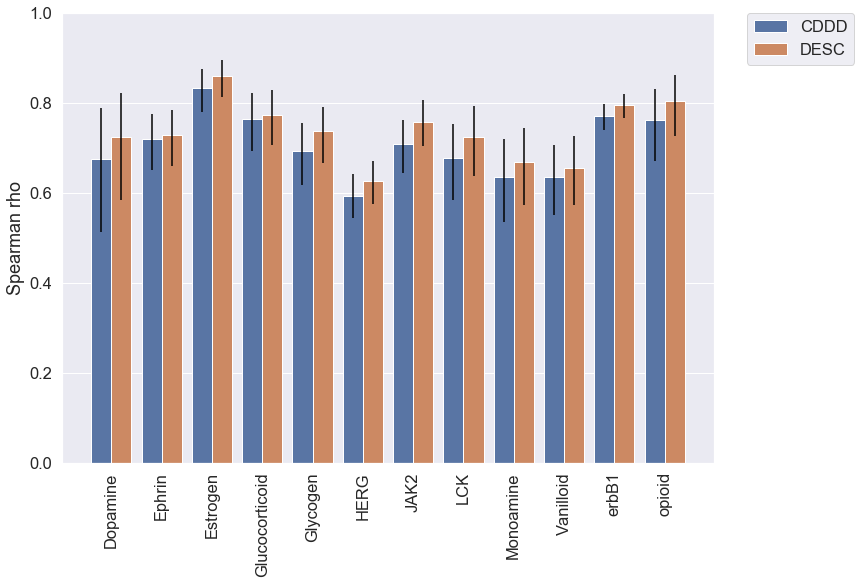

In [37]:
barplot_with_errorbars(df=sum2,
                       x_col="Target",
                       y_col="Value",
                       hue_col="Method",
                       ub_col="Lower_Bound",
                       lb_col="Upper_Bound",
                       y_label="Spearman rho",
                       x_labels="vertical")

Same behavior, no difference at the 95% confidence level.